<a href="https://colab.research.google.com/github/Zahid8/Pytorch-Geometric/blob/main/Playlist_link_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/karate.html

https://networkx.org/documentation/networkx-1.10/_modules/networkx/generators/social.html#karate_club_graph

https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/yelp.html#Yelp

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm7.html#QM7b

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(30,30))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 


In [2]:
#!wget https://raw.githubusercontent.com/Zahid8/Pytorch-Geometric/main/playlist_data.csv
import torch
import urllib.request
from torch_geometric.data import InMemoryDataset, download_url, Data


class Playlist(InMemoryDataset):

    url = 'https://raw.githubusercontent.com/Zahid8/Pytorch-Geometric/main/playlist_data.csv'

    def __init__(self, root, transform=None, pre_transform=None,
                 pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'playlist_data.csv'

    @property
    def processed_file_names(self):
        return 'data.csv'

    def download(self):
        filename, headers = urllib.request.urlretrieve(self.url, filename="playlist_data.csv")
        download_url(self.url, self.raw_dir)

    def process(self):
        import pandas as pd

        df = pd.read_csv("/content/playlist_data.csv")
        df=df.drop(['artistname','trackname','playlistname','weighted_tags'], axis=1)
        df2=df
        df2['s_key'] = df2['song_key']
        df2['s_key'] = df2['s_key'].astype(str)
        df2=df2.groupby(['user_key', 'playlist_key'] ,as_index=False).agg({
            's_key': lambda x: ','.join(x),
        })
        df2['s_key'] = df2['s_key'].str.split(',')
        df2["identifier"] = df2['user_key'].astype(str) +","+df2["playlist_key"].astype(str)
        df2['identifier'] = df2['identifier'].str.split(',')
        df2=df2.drop(['user_key','playlist_key'], axis=1)

        for i, j in df2.iterrows():
            for x in range(len(j[0])):
                j[0][x] = int(j[0][x])
            for x in range(len(j[1])):
                j[1][x] = int(j[1][x])
                
        df3=df2 
        df3['edge_pairs'] = df3.index

        all_arr=[]
        for i, j in df3.iterrows():
            all_arr.append(j[0])  
            

        for i in range(len(all_arr)):
            temp_arr=[]
            a_set = set(all_arr[i])
            for j in range(i+1,len(all_arr)):
                val_arr = []
                b_set = set(all_arr[j])
                if(a_set & b_set):
                    val_arr.append(i)
                    val_arr.append(j)
                else:
                    pass
                temp_arr.append(val_arr)
            #print("i : ",i," : ",temp_arr)
            df3['edge_pairs'][i]=temp_arr


        for i in range(len(df3['edge_pairs'])):
            df3['edge_pairs'][i]=[x for x in df3['edge_pairs'][i] if x]


############ ------> Used for removing isolated nodes
        # for i in range(len(df3['edge_pairs'])):
        #     if(len(df3['edge_pairs'][i])==0):
        #         df3.drop(labels=i,axis=0,inplace=True)
        # df3.reset_index(drop=True, inplace=True)


######################################################################       
        row_arr = []
        col_arr = []
        for i in range(len(df3['edge_pairs'])):
            row=i
            for j in range(len(df3['edge_pairs'][i])):
                col = df3['edge_pairs'][i][j][1]
                row_arr.append(row)
                col_arr.append(col)
                row_arr.append(col)
                col_arr.append(row)
        edge_index = torch.tensor([row_arr, col_arr])
        dat_len = len(df3)
        y = torch.ones(dat_len, dtype=int)
        x = torch.eye(y.size(0), dtype=torch.float)
        train_mask = torch.ones(y.size(0), dtype=bool)

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

        data = data if self.pre_transform is None else self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])


In [3]:
dataset = Playlist("/content")

Processing...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

In [4]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Playlist():
Number of graphs: 1
Number of features: 3424
Number of classes: 2


In [5]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[3424, 3424], edge_index=[2, 98586], y=[3424], train_mask=[3424])
Number of nodes: 3424
Number of edges: 98586
Average node degree: 28.79
Number of training nodes: 3424
Training node label rate: 1.00
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[   0,  793],
        [ 793,    0],
        [   1,    3],
        ...,
        [3406, 3404],
        [3405, 3406],
        [3406, 3405]])


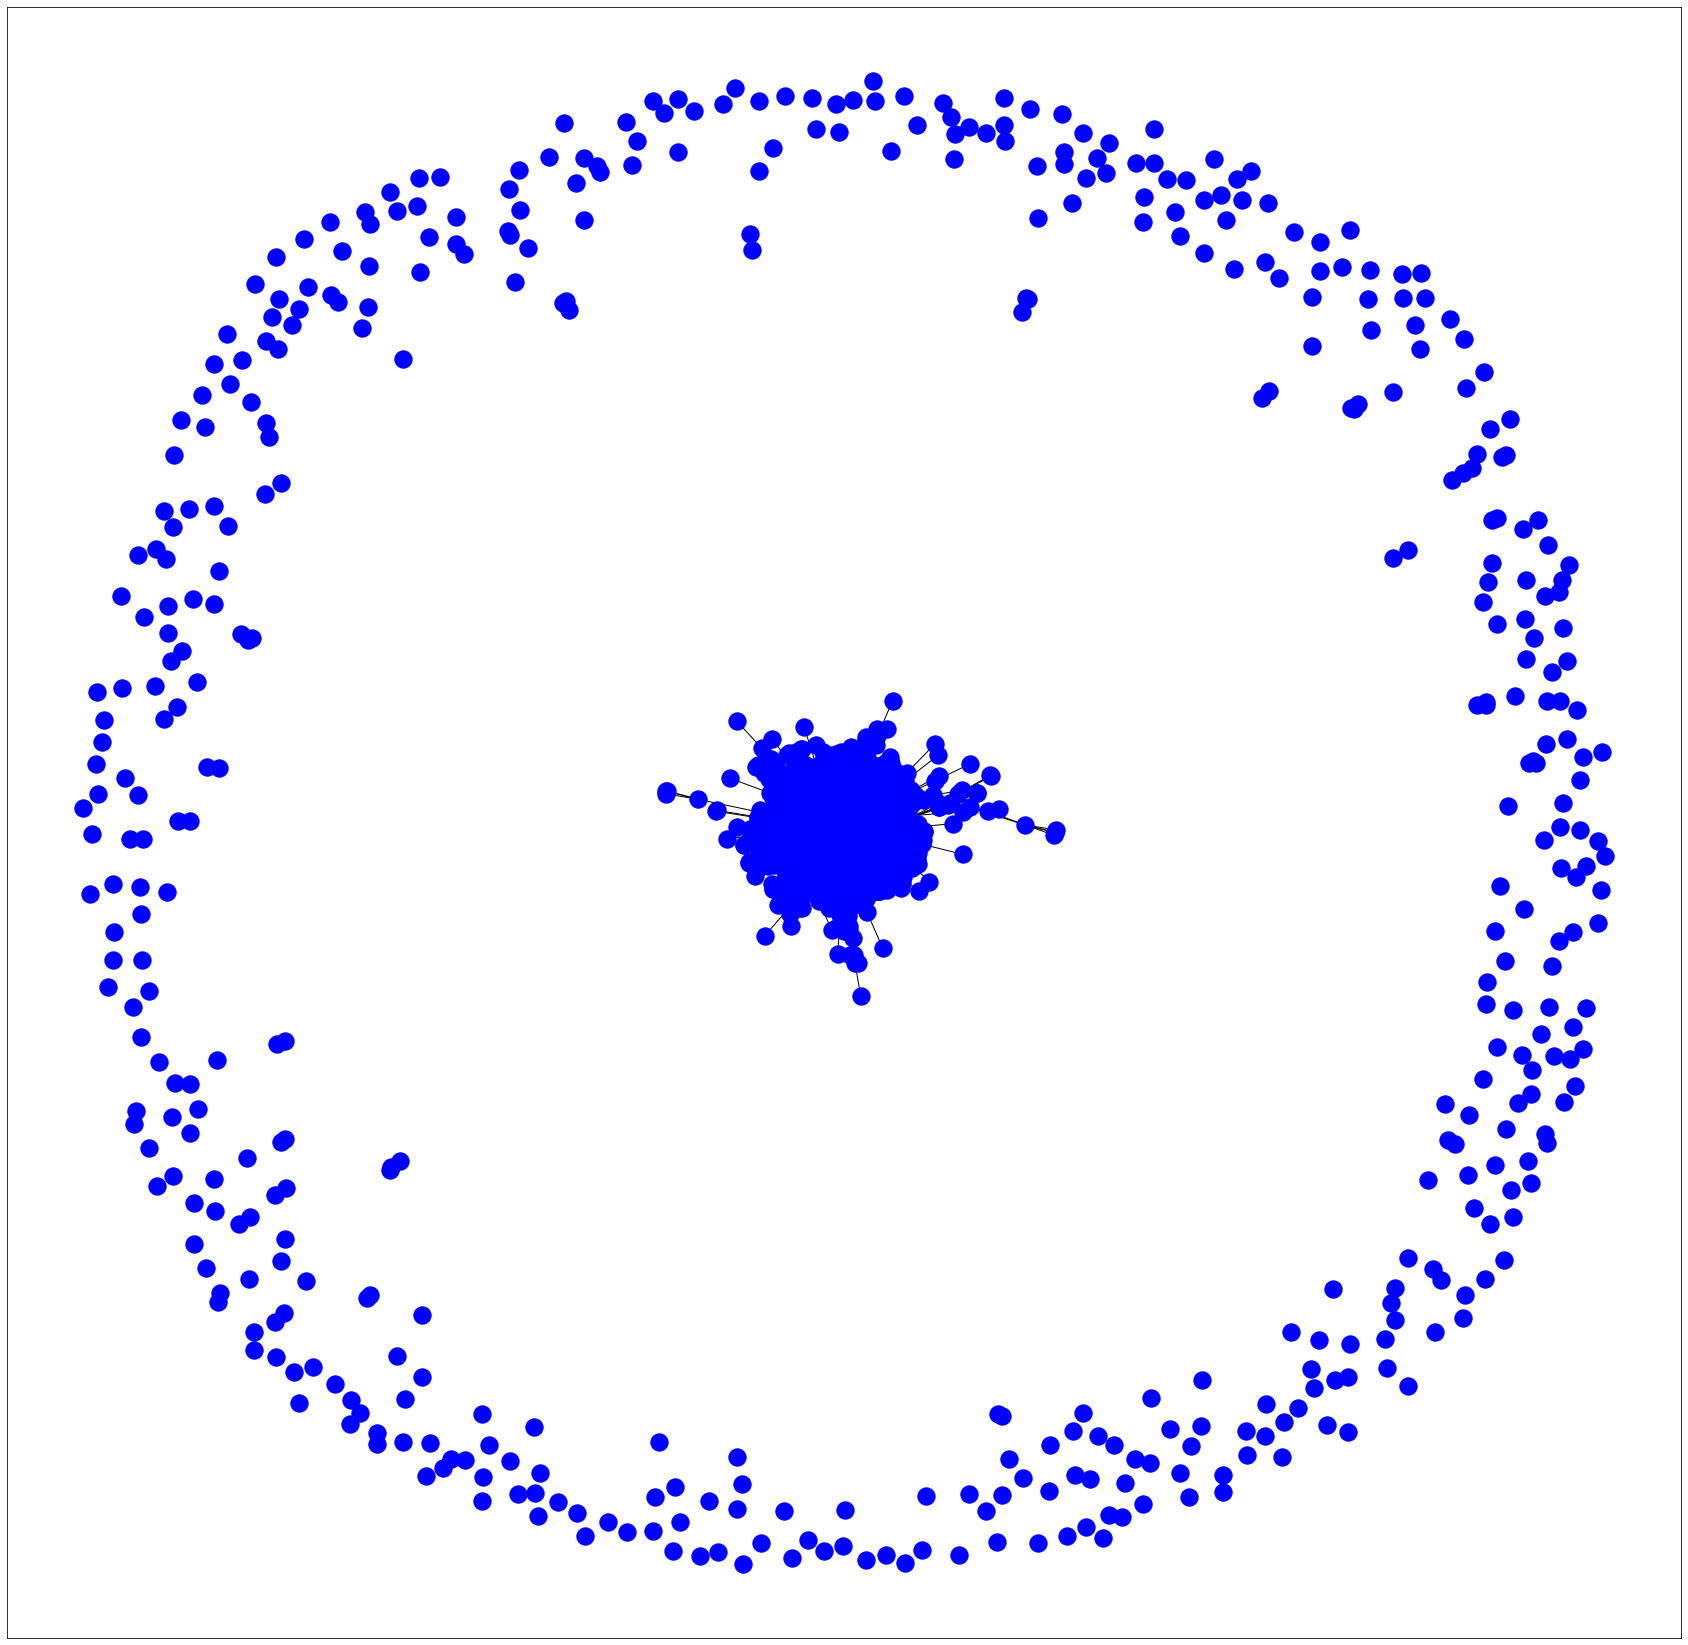

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G,color='blue')

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 10)
        self.conv2 = GCNConv(10, 10)
        self.conv3 = GCNConv(10, 5)
        #self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        #out = self.classifier(h)

        return h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(2638, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 5)
)


In [ ]:
model = GCN()

h = model(data.x, data.edge_index)
#print(f'Embedding shape: {list(h.shape)}')

#visualize_embedding(h, color='blue')

RuntimeError: ignored

<IPython.core.display.Javascript object>

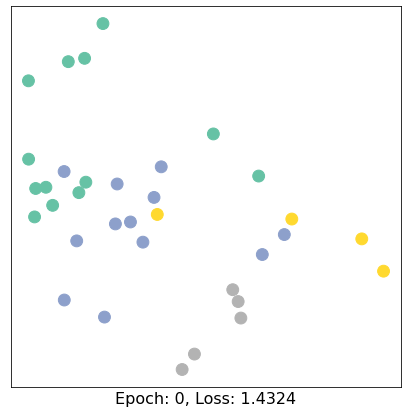

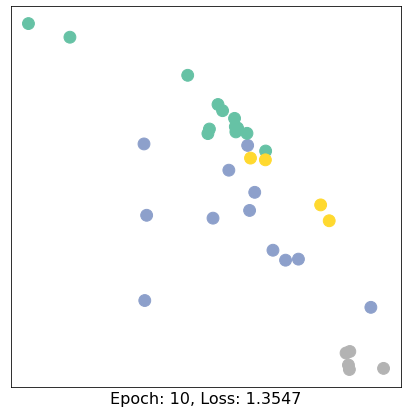

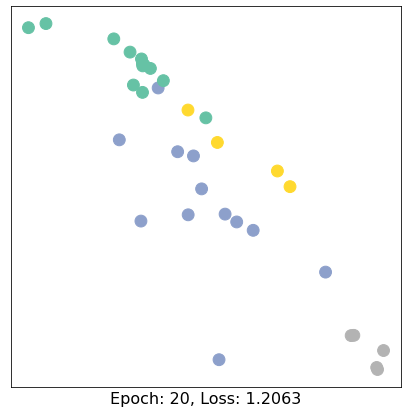

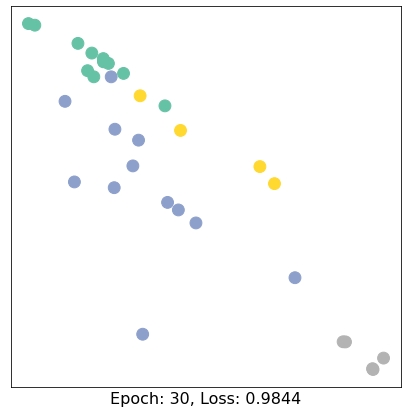

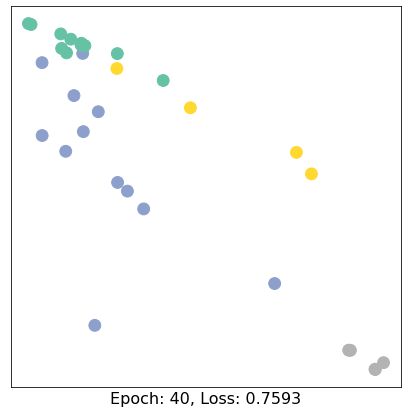

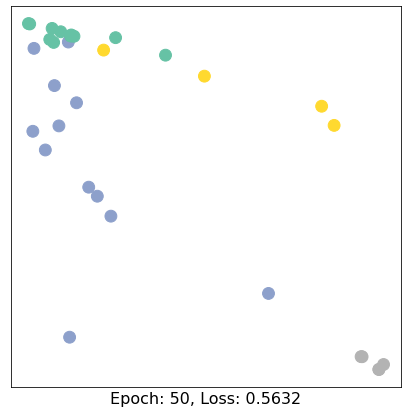

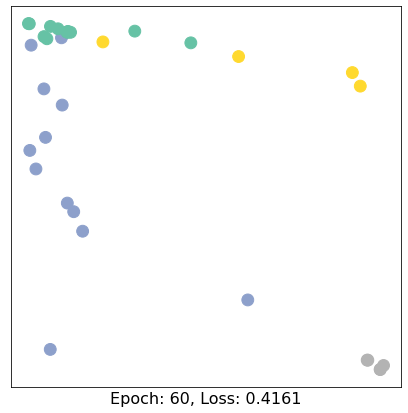

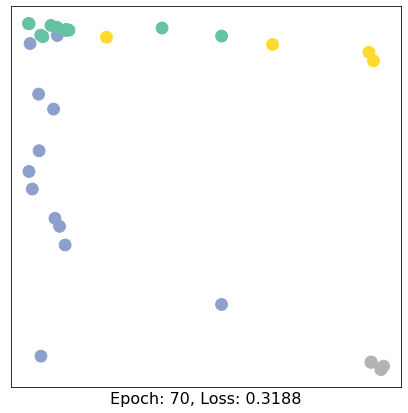

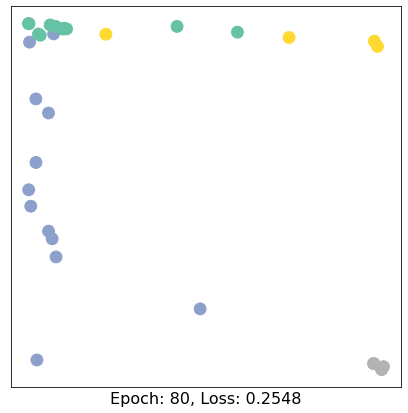

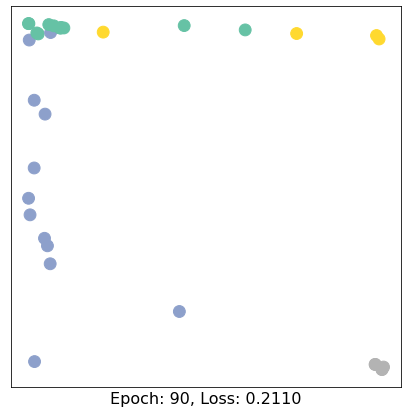

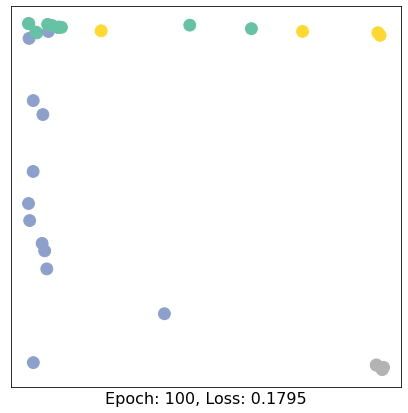

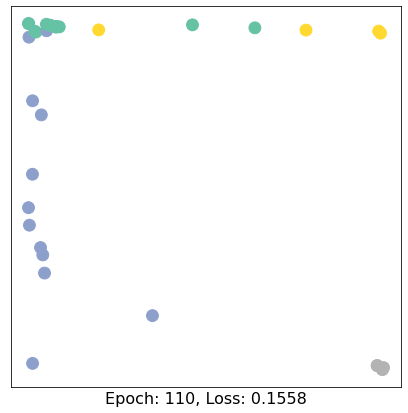

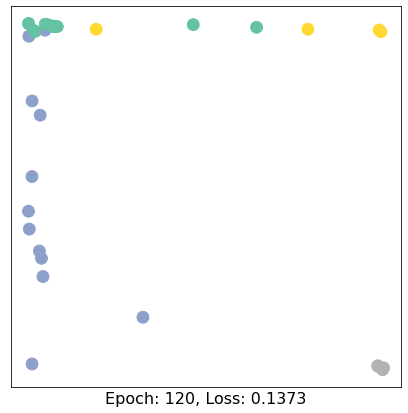

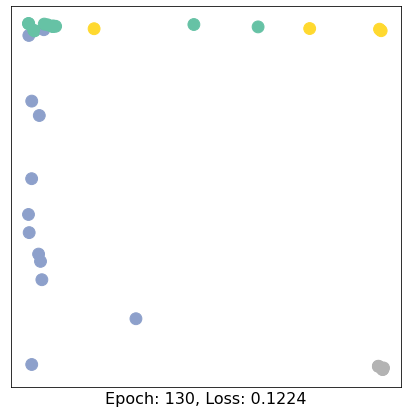

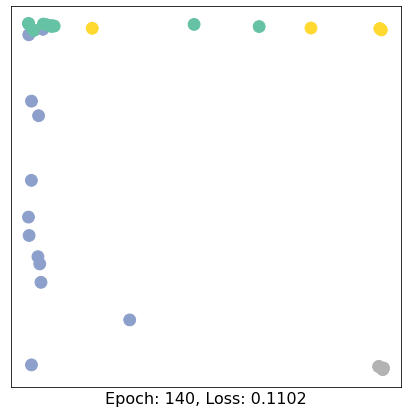

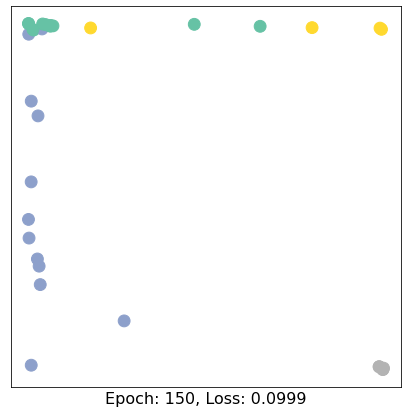

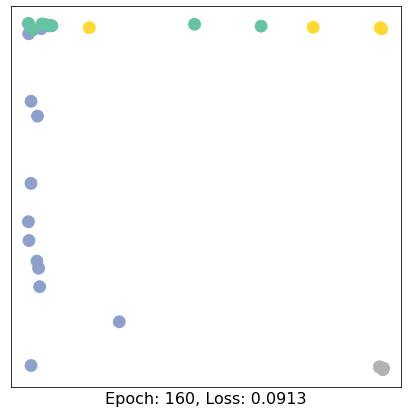

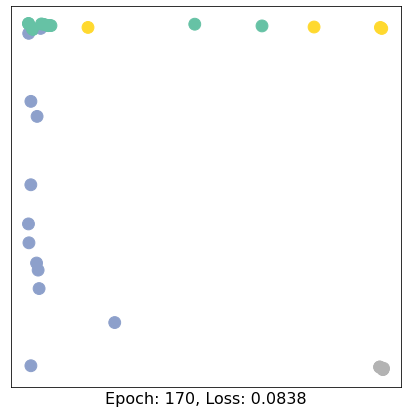

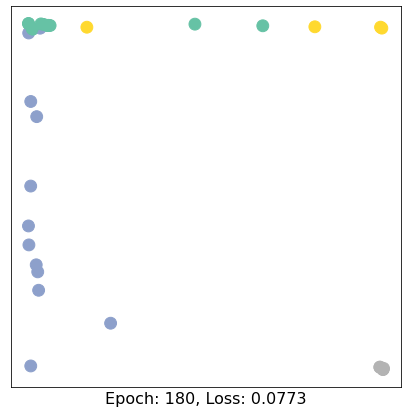

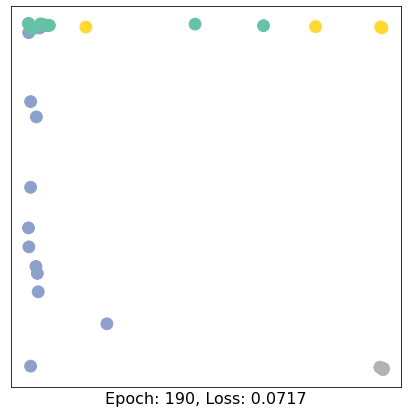

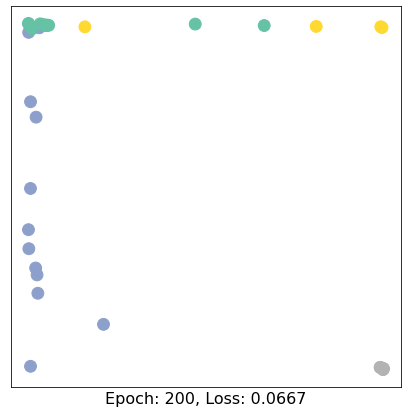

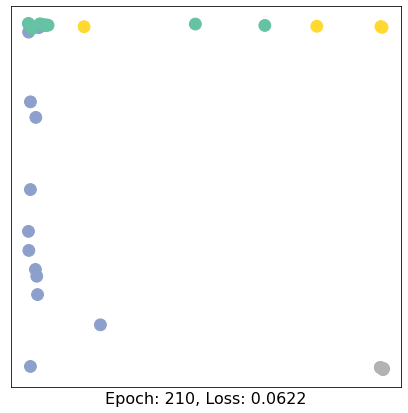

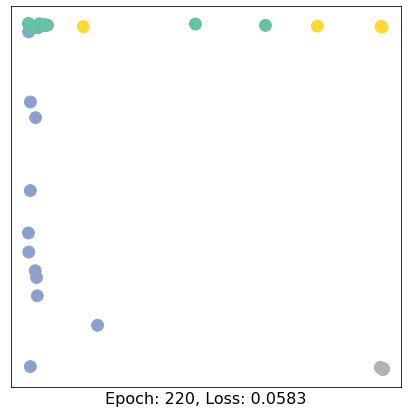

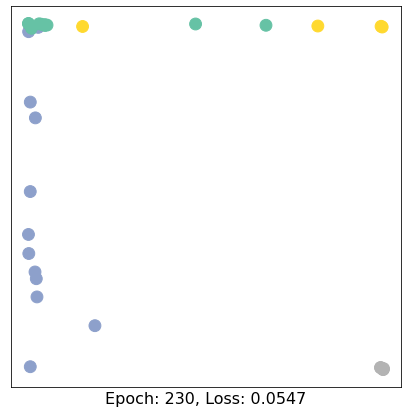

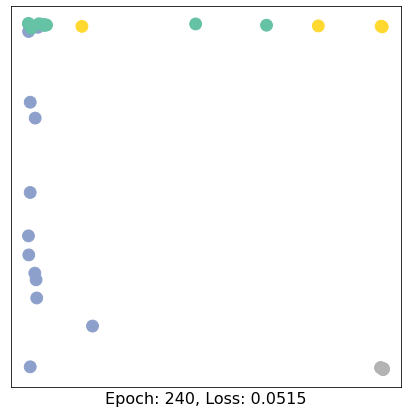

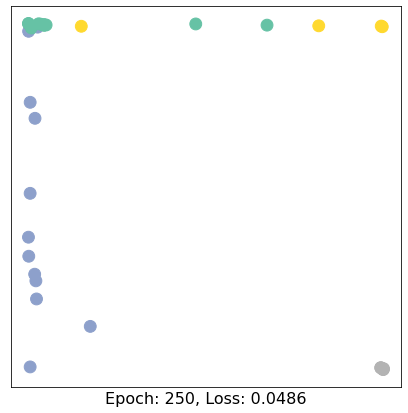

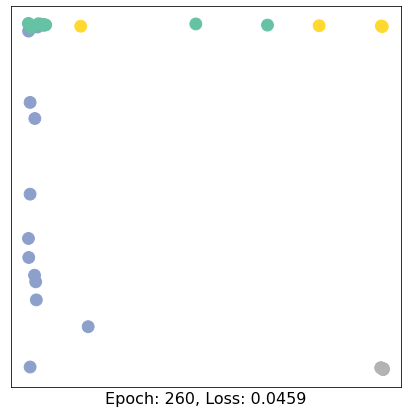

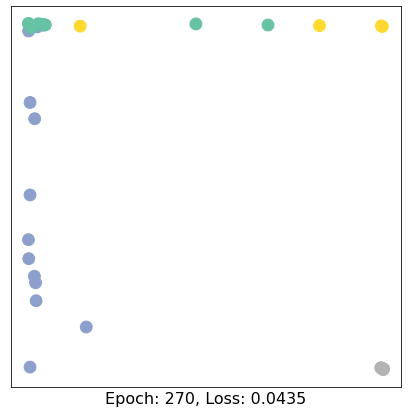

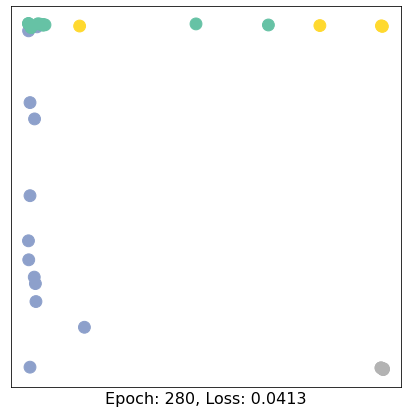

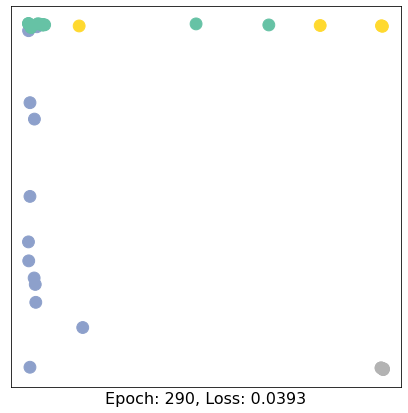

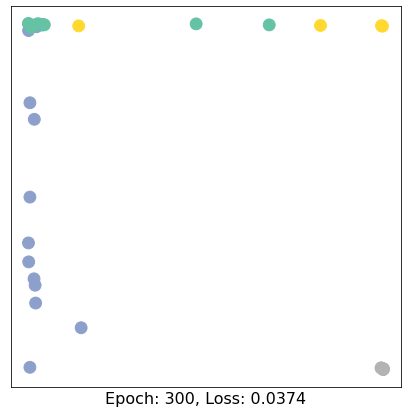

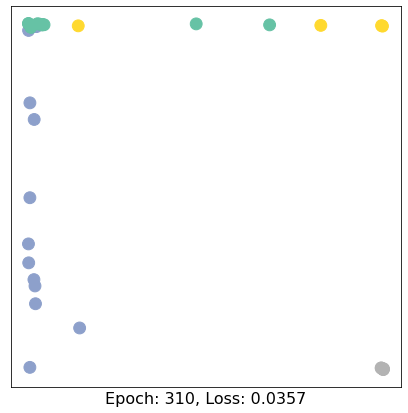

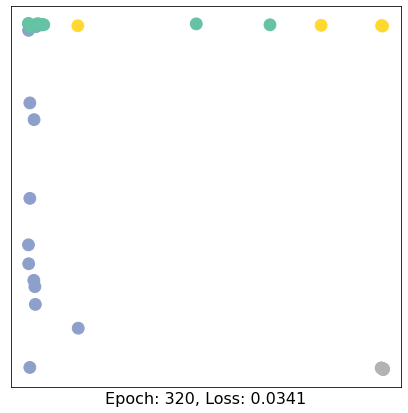

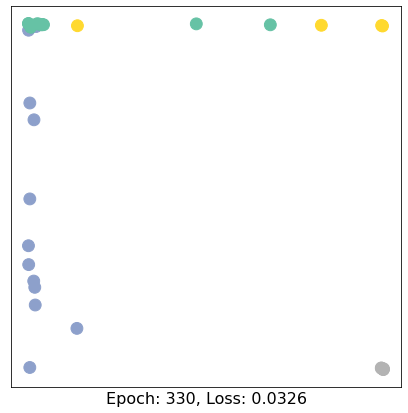

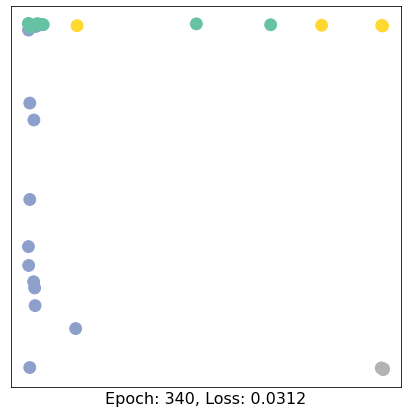

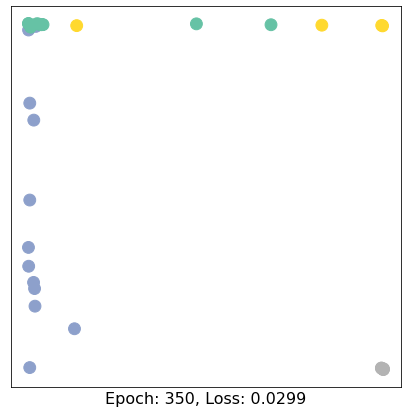

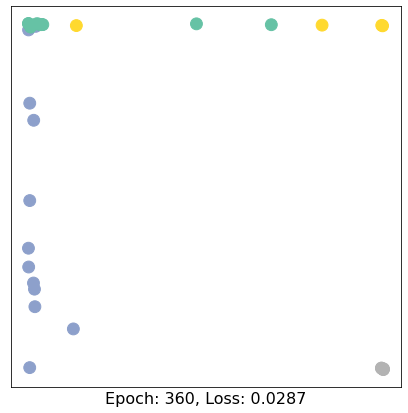

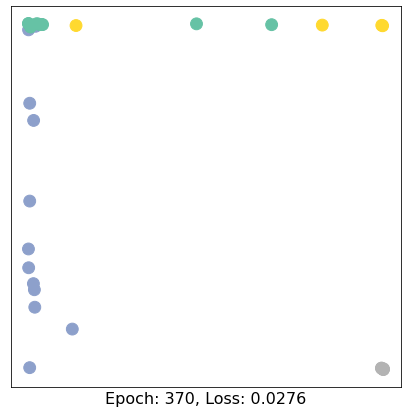

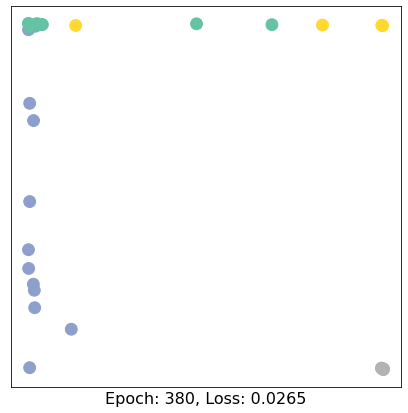

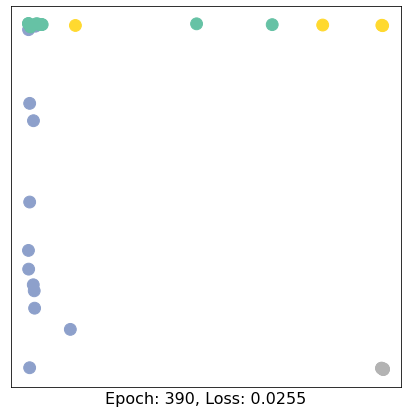

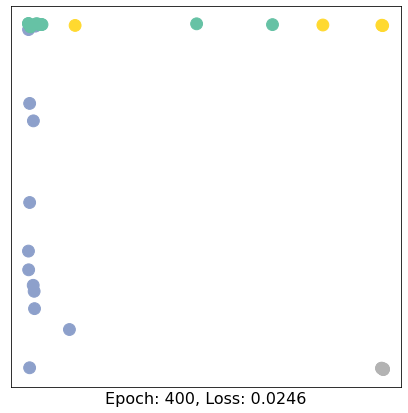

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# **LINK PREDICTION**

In [11]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])
#path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
#dataset = Planetoid(path, name='Cora', transform=transform)
dataset = Playlist(root="/content",transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6932, Val: 0.8254, Test: 0.8266
Epoch: 002, Loss: 0.6909, Val: 0.8863, Test: 0.8922
Epoch: 003, Loss: 0.6723, Val: 0.8896, Test: 0.8957
Epoch: 004, Loss: 0.6348, Val: 0.8914, Test: 0.8972
Epoch: 005, Loss: 0.6382, Val: 0.8950, Test: 0.8997
Epoch: 006, Loss: 0.5947, Val: 0.8962, Test: 0.9000
Epoch: 007, Loss: 0.5844, Val: 0.8938, Test: 0.8950
Epoch: 008, Loss: 0.5712, Val: 0.8908, Test: 0.8908
Epoch: 009, Loss: 0.5458, Val: 0.8893, Test: 0.8888
Epoch: 010, Loss: 0.5385, Val: 0.8827, Test: 0.8809
Epoch: 011, Loss: 0.5425, Val: 0.8632, Test: 0.8605
Epoch: 012, Loss: 0.5443, Val: 0.8582, Test: 0.8555
Epoch: 013, Loss: 0.5433, Val: 0.8714, Test: 0.8686
Epoch: 014, Loss: 0.5358, Val: 0.8798, Test: 0.8774
Epoch: 015, Loss: 0.5331, Val: 0.8816, Test: 0.8794
Epoch: 016, Loss: 0.5297, Val: 0.8821, Test: 0.8800
Epoch: 017, Loss: 0.5294, Val: 0.8852, Test: 0.8834
Epoch: 018, Loss: 0.5292, Val: 0.8887, Test: 0.8873
Epoch: 019, Loss: 0.5265, Val: 0.8904, Test: 0.8894
Epoch: 020, 

In [13]:
z1 = model.encode(val_data.x, val_data.edge_index)
val_edge_index = model.decode_all(z1)
val_edge_index

tensor([[   0,    0,    0,  ..., 3423, 3423, 3423],
        [   0,    1,    2,  ..., 3421, 3422, 3423]])

In [17]:
val_edge_index.shape

torch.Size([2, 5698462])

In [32]:
import torch
import pandas as  pd
%reload_ext google.colab.data_table
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
pd.set_option('display.max_columns', 10000)
px = pd.DataFrame(val_edge_index.numpy())
px

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [34]:
adj_mat_val=torch.sparse.FloatTensor(
    val_edge_index, 
    torch.ones(val_edge_index.shape[1]), 
    (val_edge_index.max(axis=1).values + 1).tolist())

In [40]:
adj_mat_val

tensor(indices=tensor([[   0,    0,    0,  ..., 3423, 3423, 3423],
                       [   0,    1,    2,  ..., 3421, 3422, 3423]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(3424, 3424), nnz=5698462, layout=torch.sparse_coo)

In [35]:
import torch
import pandas as  pd
%reload_ext google.colab.data_table
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
px = pd.DataFrame(adj_mat_val.numpy())
px

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


TypeError: ignored